In [1]:
import moviepy.video.io.VideoFileClip as mpy
import moviepy.editor as mpyeditor
import cv2 as cv

import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

In [2]:
vid = mpy.VideoFileClip("../TermProjectFiles/Part3/movie_001.avi")
frame_count = vid.reader.nframes
video_fps = vid.fps

vid_frame = list()
for i in range(frame_count):
    vid_frame.append(vid.get_frame(i*1.0/video_fps))

## Dense Flow Approach

In [3]:
def give_coord(mask_arr):
    return int(np.median(np.where(mask_arr)[0])), int(np.median(np.where(mask_arr)[1]))

In [4]:
def find_circles(img):
    
    img_cp = deepcopy(img)
    img_cp = cv.cvtColor(img_cp, cv.COLOR_RGB2HSV)
    green_mask = cv.inRange(img_cp, (60, 25, 25), (80, 255,255))
    blue_mask = cv.inRange(img_cp, (105, 25, 25), (125, 255,255))
    red_mask = cv.inRange(img_cp, (165, 50, 50), (180, 255,255))
    pink_mask = cv.inRange(img_cp, (150, 25, 25), (170, 255,255))
    
    green_imask = green_mask > 0
    green = np.zeros_like(img, np.uint8)
    green[green_imask] = img[green_imask]

    blue_imask = blue_mask > 0
    blue = np.zeros_like(img, np.uint8)
    blue[blue_imask] = img[blue_imask]

    red_imask = red_mask > 0
    red = np.zeros_like(img, np.uint8)
    red[red_imask] = img[red_imask]

    pink_imask = pink_mask > 0
    pink = np.zeros_like(img, np.uint8)
    pink[pink_imask] = img[pink_imask]
    
    p0 = np.array([
    [give_coord(red_imask)],
    [give_coord(green_imask)],
    [give_coord(blue_imask)],
    [give_coord(pink_imask)]
    ])
    
    return p0

In [5]:
red_vec = []
green_vec = []
blue_vec = []
pink_vec = []

for i in range(frame_count-1):
    if i % 25 == 0:
        print(i)
    circle_coords = find_circles(vid_frame[i])
    prvs = cv.cvtColor(vid_frame[i], cv.COLOR_RGB2GRAY)
    nxt = cv.cvtColor(vid_frame[i+1], cv.COLOR_RGB2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs, nxt, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    red_vec.append(flow[circle_coords[0, 0, 0], circle_coords[0, 0, 1], :].astype(np.float32))
    green_vec.append(flow[circle_coords[1, 0, 0], circle_coords[1, 0, 1], :].astype(np.float32))
    blue_vec.append(flow[circle_coords[2, 0, 0], circle_coords[2, 0, 1], :].astype(np.float32))
    pink_vec.append(flow[circle_coords[3, 0, 0], circle_coords[3, 0, 1], :].astype(np.float32))

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375
1400
1425
1450
1475
1500
1525
1550
1575
1600
1625
1650
1675
1700
1725
1750
1775
1800
1825
1850
1875
1900
1925
1950
1975
2000
2025
2050
2075
2100
2125
2150


In [6]:
def calc_speed(arr):
    a = np.sum(np.array(arr)**2, axis=1)
    return np.sum(np.sqrt(a))/(frame_count-2)

### Speeds

In [7]:
print(f"Red: {calc_speed(red_vec)} pixels/frame")
print(f"Green: {calc_speed(green_vec)} pixels/frame")
print(f"Blue: {calc_speed(blue_vec)} pixels/frame")
print(f"Pink: {calc_speed(pink_vec)} pixels/frame")

Red: 3.503964013401109 pixels/frame
Green: 1.5493203549199976 pixels/frame
Blue: 3.0940148993472736 pixels/frame
Pink: 0.30066538474035354 pixels/frame


## Failed Attempts

In [8]:
feature_params = dict(maxCorners = 100,
                      qualityLevel = 0.3,
                      minDistance = 7,
                      blockSize = 7)

In [9]:
def good_frame(frame):
    new_frame = np.zeros((frame.shape[0] + 250, frame.shape[1] + 250))
    pts = find_circles(frame)
    for i in range(pts.shape[0]):
        new_frame[125+(pts[i, 0, 0]-10):125+(pts[i, 0, 0]+11), 125+(pts[i, 0, 1]-10):125+(pts[i, 0, 1]+11)] = 1
    
    return new_frame.astype(np.uint8)

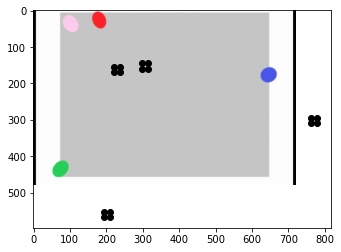

In [10]:
i = 2100
found_pt = cv.goodFeaturesToTrack(good_frame(vid_frame[i]), mask = None, **feature_params)
plt.imshow(vid_frame[i], cmap="gray")
plt.scatter(found_pt[:, 0, 0], found_pt[:, 0, 1], color="black")

In [11]:
def optical_flow(curr_frame, next_frame, center_pt, window_size, gauss_kernel = None):
    """
    Optical flow implementation with lucas-kanade.
    """
    assert window_size % 2 == 1
    assert window_size >= 3
    half = window_size // 2
    
    if gauss_kernel is None:
        gauss_kernel = window_size
    elif gauss_kernel == 0:
        gauss_kernel = window_size
    
    # Convert the frames into grayscale
    curr_img, next_img = deepcopy(curr_frame), deepcopy(next_frame)
    curr_gray, next_gray = curr_img, next_img
    curr_gray, next_gray = np.float32(curr_gray), np.float32(next_gray)
    
    # Create the windows with the given window size
    curr_window = curr_gray[center_pt[1]-half:center_pt[1]+half+1, center_pt[0]-half:center_pt[0]+half+1]
    next_window = next_gray[center_pt[1]-half:center_pt[1]+half+1, center_pt[0]-half:center_pt[0]+half+1]
    
    larger_window = curr_gray[center_pt[1]-half-1:center_pt[1]+half+2, center_pt[0]-half-1:center_pt[0]+half+2]
    
    # Apply Gaussian Blur on the windows
    curr_window = cv.GaussianBlur(curr_window, (gauss_kernel, gauss_kernel), 0)
    next_window = cv.GaussianBlur(next_window, (gauss_kernel, gauss_kernel), 0)
    larger_window = cv.GaussianBlur(larger_window, (gauss_kernel+2, gauss_kernel+2), 0)
    
    # Calculate gradients
    I_x = (larger_window[1:-1, 1:-1] - larger_window[1:-1, 0:-2])
    I_y = (larger_window[1:-1,1:-1] - larger_window[0:-2, 1:-1])
    I_t = next_window - curr_window
    
    # Solve the overdetermined system (close form least squares solution)
    sol = np.matmul(np.linalg.pinv(np.array([[np.sum(I_x**2), np.sum(I_x*I_y)], [np.sum(I_x*I_y), np.sum(I_y**2)]])), -1 * np.array([[np.sum(I_x * I_t)], [np.sum(I_y * I_t)]]))
    return sol

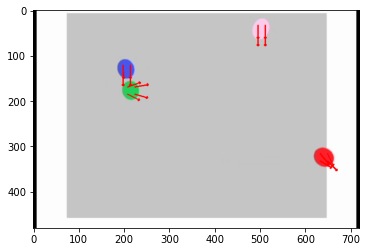

In [12]:
vectored_images = list()
w_size = 49
kernel_size = 31

i = 18

p0 = cv.goodFeaturesToTrack(good_frame(vid_frame[i]), mask = None, **feature_params)
pts = [(int(p0[abc, 0, 0]), int(p0[abc, 0, 1])) for abc in range(16)]

ans = [optical_flow(good_frame(vid_frame[i]),
                    good_frame(vid_frame[i+1]),
                    (pts[abc][0], pts[abc][1]), w_size, kernel_size) for abc in range(16)]

draw_vec = [
    (normalize(ans[abc], axis=0) * 30).astype(np.int) for abc in range(16)
]

cp_image = deepcopy(vid_frame[i])
for abc in range(16):
    cv.arrowedLine(cp_image, (pts[abc][0]-125, pts[abc][1]-125), (pts[abc][0] + draw_vec[abc][0]-125, pts[abc][1] + draw_vec[abc][1]-125), 255, thickness=2)

vectored_images.append(cp_image)

plt.imshow(vectored_images[0])

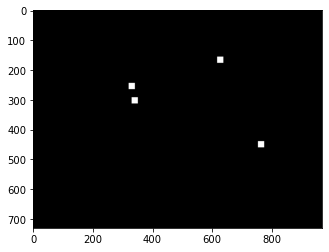

In [13]:
plt.imshow(good_frame(vid_frame[18]), cmap="gray")

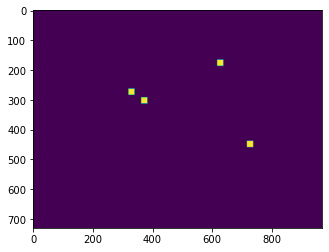

In [14]:
plt.imshow(good_frame(vid_frame[19]))

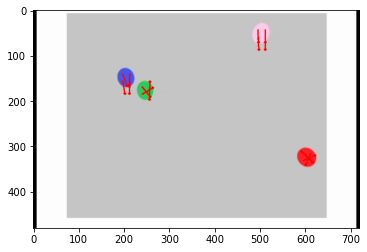

In [15]:
vectored_images = list()
w_size = 51
kernel_size = 51

i = 19

p0 = cv.goodFeaturesToTrack(good_frame(vid_frame[i]), mask = None, **feature_params)
pts = [(int(p0[abc, 0, 0]), int(p0[abc, 0, 1])) for abc in range(16)]

ans = [optical_flow(good_frame(vid_frame[i]),
                    good_frame(vid_frame[i+1]),
                    (pts[abc][0], pts[abc][1]), w_size, kernel_size) for abc in range(16)]

draw_vec = [
    (normalize(ans[abc], axis=0) * 30).astype(np.int) for abc in range(16)
]

cp_image = deepcopy(vid_frame[i])
for abc in range(16):
    cv.arrowedLine(cp_image, (pts[abc][0]-125, pts[abc][1]-125), (pts[abc][0] + draw_vec[abc][0]-125, pts[abc][1] + draw_vec[abc][1]-125), 255, thickness=2)

vectored_images.append(cp_image)

plt.imshow(vectored_images[0])

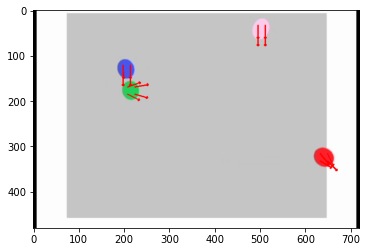

In [16]:
vectored_images = list()
w_size = 49
kernel_size = 31

for i in range(frame_count - 1):
    if i == 1:
        break
    i = 18
    p0 = cv.goodFeaturesToTrack(good_frame(vid_frame[i]), mask = None, **feature_params)
    pts = [(int(p0[abc, 0, 0]), int(p0[abc, 0, 1])) for abc in range(16)]
    
    ans = [optical_flow(good_frame(vid_frame[i]),
                        good_frame(vid_frame[i+1]),
                        (pts[abc][0], pts[abc][1]), w_size, kernel_size) for abc in range(16)]
    
    draw_vec = [
        (normalize(ans[abc], axis=0) * 30).astype(np.int) for abc in range(16)
    ]
    
    cp_image = deepcopy(vid_frame[i])
    for abc in range(16):
        cv.arrowedLine(cp_image, (pts[abc][0]-125, pts[abc][1]-125), (pts[abc][0] + draw_vec[abc][0]-125, pts[abc][1] + draw_vec[abc][1]-125), 255, thickness=2)
        
    vectored_images.append(cp_image)
plt.imshow(vectored_images[0])